# This notebook trying to check the depth data from the sensors

#### Author: Jax
#### Date: 06-21-2023


In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib3
urllib3.disable_warnings()
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker
import matplotlib.transforms as transforms
import matplotlib.patches as mpatches
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write.retry import WritesRetry
from influxdb_client.client.write_api import SYNCHRONOUS
import geocoder
import glob
from influxdb_client.domain.write_precision import WritePrecision
sns.set(rc = {'figure.figsize':(18,10)})
from scipy.ndimage import gaussian_filter1d

In [3]:
def query_from_influxdb(_url=None,
                        _token=None,
                        _org=None,
                        _id=None,
                        _bucket_name=None,
                        _columns_to_drop=None,
                        _measurement=None,
                        _field=None, ):
    
    """
        Function to query InfluxDB using influxdb-python-client library from https://github.com/influxdata/influxdb-client-python
            :param _measurement: Available options are flood-sensor-tidal-sensor-rain-gauge,weather,etc. Default is flood-sensor
            :param _field: Available options include batt_v and cloud_percent 
            :param _url: InfluxDB url
            :param _token: API token with read-access
            :param _org: InfluxDB organization name
            :param _id: Sensor/Deployment ID
            :param _bucket_name: Name of the bucket
            :param _columns_to_drop: Array-like column names to be dropped
        :returns a dataframe with all columns except dropped ones if any
    """
    result = []
    p = {"_id_value": _id,
         "_bucket_name": _bucket_name,
         "_measurement": _measurement, 
         "_field": _field, }


    with InfluxDBClient(url=_url, token=_token, org=_org, timeout=1000000) as client:
        query_api = client.query_api()
        if _measurement=="weather":  
            result = query_api.query_data_frame('''from(bucket: _bucket_name)
                                                  |> range(start: -40d, stop: now())
                                                  |> filter(fn: (r) => r["_measurement"] == _measurement)
                                                  |> filter(fn: (r) => r["_field"] == _field)
                                                  |> filter(fn: (r) => r["sensor_id"] == _id_value)
                                                  |> pivot(rowKey: ["_time"], columnKey: ["_field"], valueColumn: "_value")
                                                ''', params=p)   
        else:        
            result = query_api.query_data_frame('''from(bucket: _bucket_name)
                                                |> range(start: -40d)       
                                                |> filter(fn: (r) => r["_measurement"] == _measurement)
                                                |> filter(fn: (r) => r["deployment_id"] == _id_value)
                                                |> pivot(rowKey: ["_time"], columnKey: ["_field"], valueColumn: "_value")
                                                ''', params=p)

        if type(result) == list:
            result = pd.concat(result)

    result.drop(columns=['_start', '_stop', 'result', 'table'], inplace=True) #result
    result.rename(columns={'_time': 'time', '_measurement': 'measurement'}, inplace=True)
    result['time'] = pd.to_datetime(result['time'], format="%Y-%m-%d %H:%M:%S.%f", utc=True)
    result.set_index('time', inplace=True)
    result = result.sort_values(by=['time'])

    return result

In [4]:
sensor_info = pd.read_excel('sensor_information.xlsx')[['deployment_id','date_down', 
                                                        'lat', 'lon', 'height_ground_mm',
                                                       'deploy_type']][1:]
sensor_info.head()

,deployment_id,date_down,lat,lon,height_ground_mm,deploy_type
1,daily_gentle_beetle,-,40.675855,-73.983944,NaN,pluvial
2,widely_proud_lizard,2021-12-10 00:00:00,40.673654,-73.995396,3000.0,pluvial
3,overly_heroic_squid,-,40.673401,-73.994892,NaN,pluvial
4,weekly_poetic_guinea,-,40.676281,-73.984089,2700.0,pluvial
5,vastly_saving_whale,-,40.673267,-74.008418,NaN,pluvial


In [12]:
df= query_from_influxdb(_url='https://influxdb.floodlabs.nyc/',
                           _token='rvEpEpb9bDwrb1NbmlbnmT4HT_XCQxeKn3DHghJu9uABrm1qbHhR9D8eXsoMux9v073wttFRY6FLs6FxM7TuSw==',
                           _org='floodnet',
                           _id='overly_heroic_squid',
                          _bucket_name='floodnet-live',
                           _measurement="flood-sensor",
                           _field="depth_proc_mm",).reset_index()[['time', 'deployment_id', 'error_flag','depth_proc_mm', 'dist_mm']]
df.head()

,time,deployment_id,error_flag,depth_proc_mm,dist_mm
0,2023-05-12 18:57:20.449000+00:00,overly_heroic_squid,0,0,5000
1,2023-05-12 18:58:23.411000+00:00,overly_heroic_squid,0,0,5000
2,2023-05-12 18:59:25.984000+00:00,overly_heroic_squid,0,0,5000
3,2023-05-12 19:00:28.569000+00:00,overly_heroic_squid,0,0,5000
4,2023-05-12 19:01:31.092000+00:00,overly_heroic_squid,0,0,5000


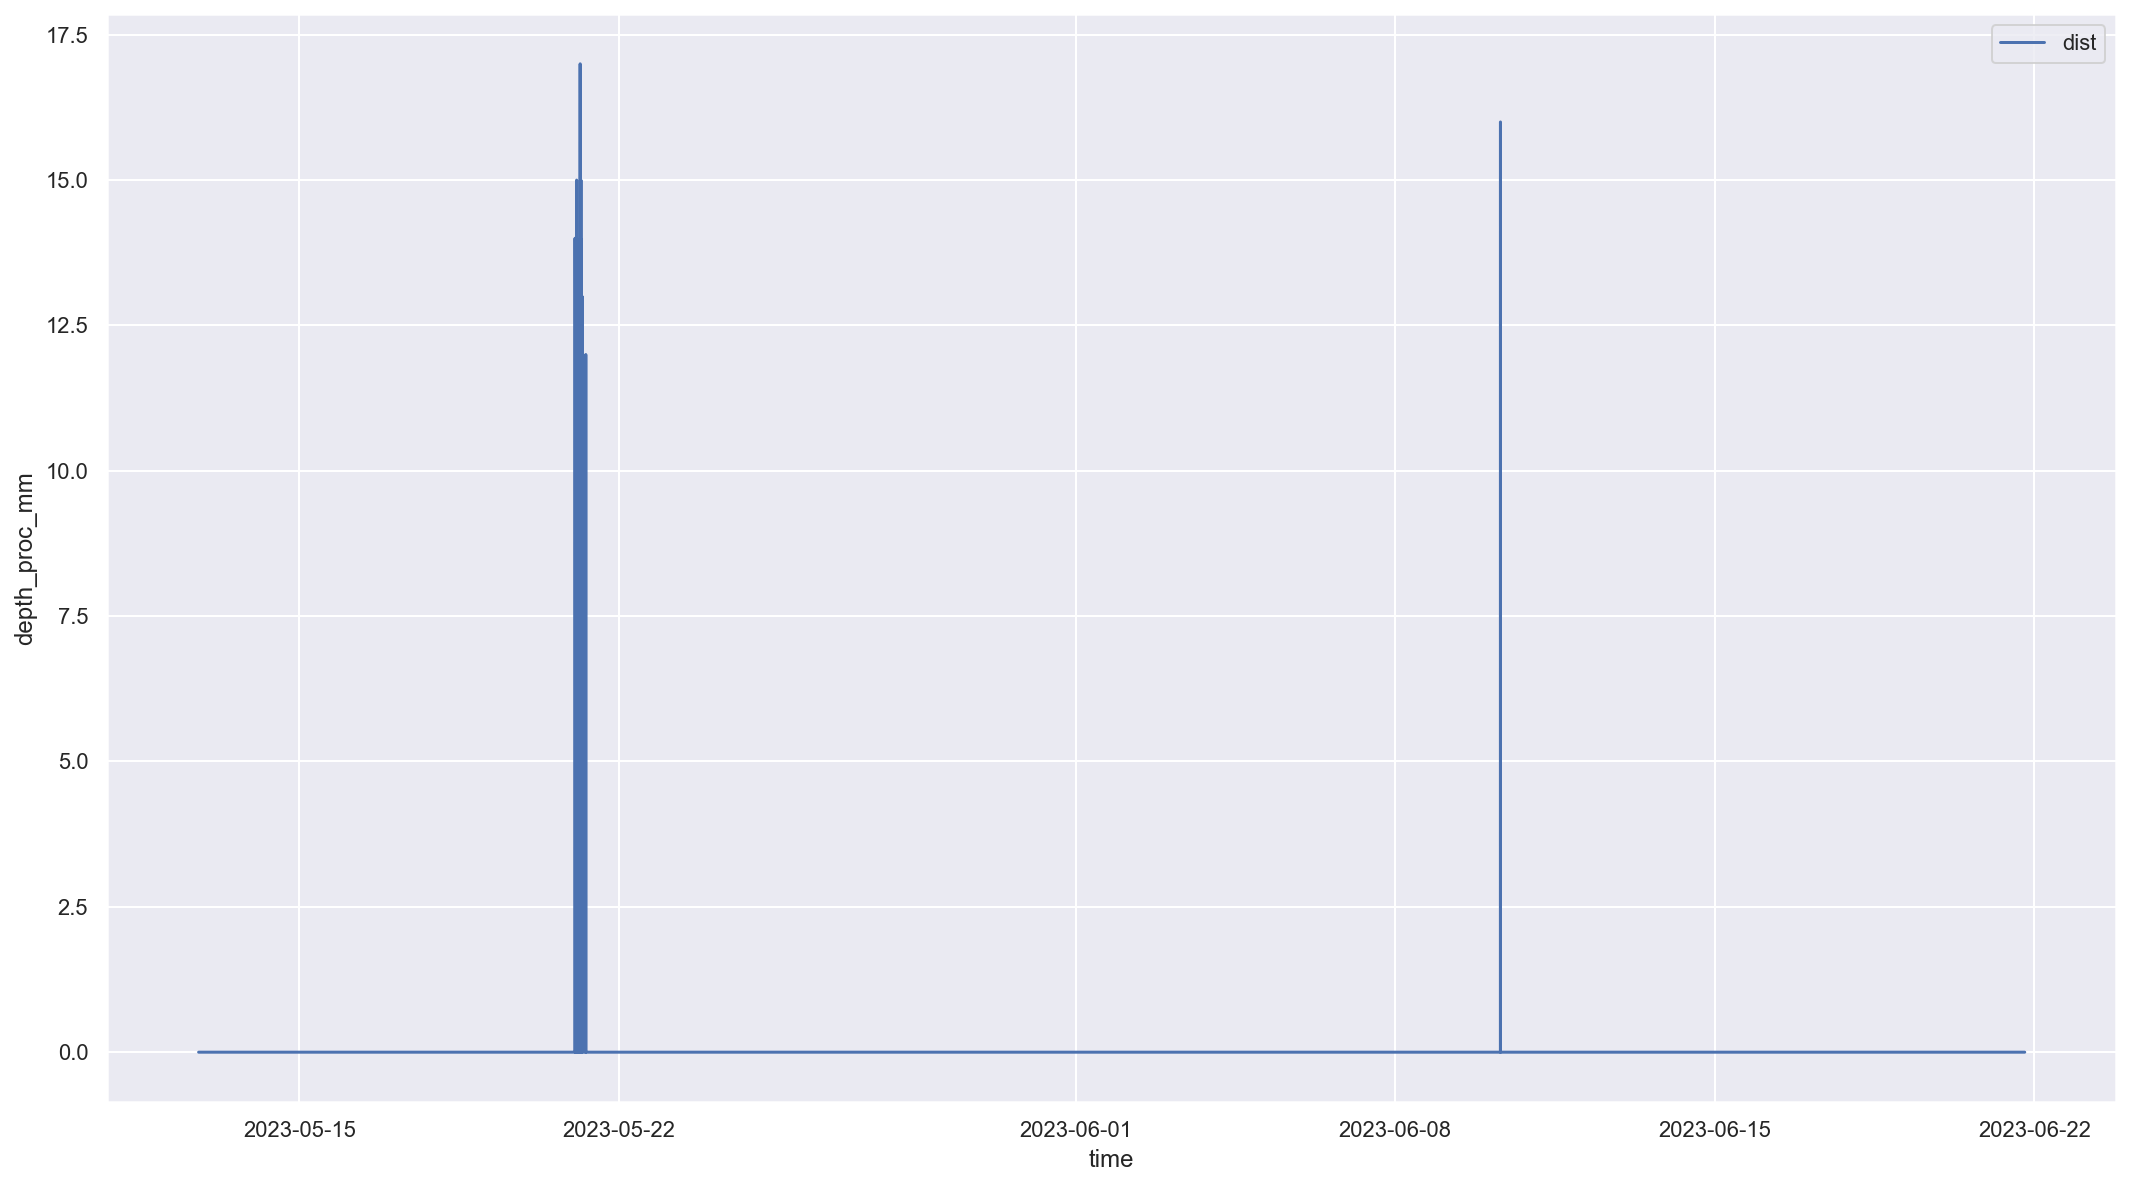

In [19]:
ax = sns.lineplot(data = df, x = 'time', y = 'depth_proc_mm', label= 'dist')
plt.savefig('1_sensor_depth_example')

In [18]:
lis = []
c = 0
for name in sensor_info['deployment_id']:
    try:
      sub = query_from_influxdb(_url='https://influxdb.floodlabs.nyc/',
                            _token='rvEpEpb9bDwrb1NbmlbnmT4HT_XCQxeKn3DHghJu9uABrm1qbHhR9D8eXsoMux9v073wttFRY6FLs6FxM7TuSw==',
                            _org='floodnet',
                            _id=name,
                            _bucket_name='floodnet-live',
                            _measurement="flood-sensor",
                            _field="depth_proc_mm",).reset_index()[['time', 'deployment_id', 'error_flag','depth_proc_mm', 'dist_mm']]
      lis.append(sub)
    except:
      pass
    #print(name)
all_dep = pd.concat(lis)
all_dep.shape

(1657094, 5)

In [35]:
#all_dep.to_csv('all_depth.csv')

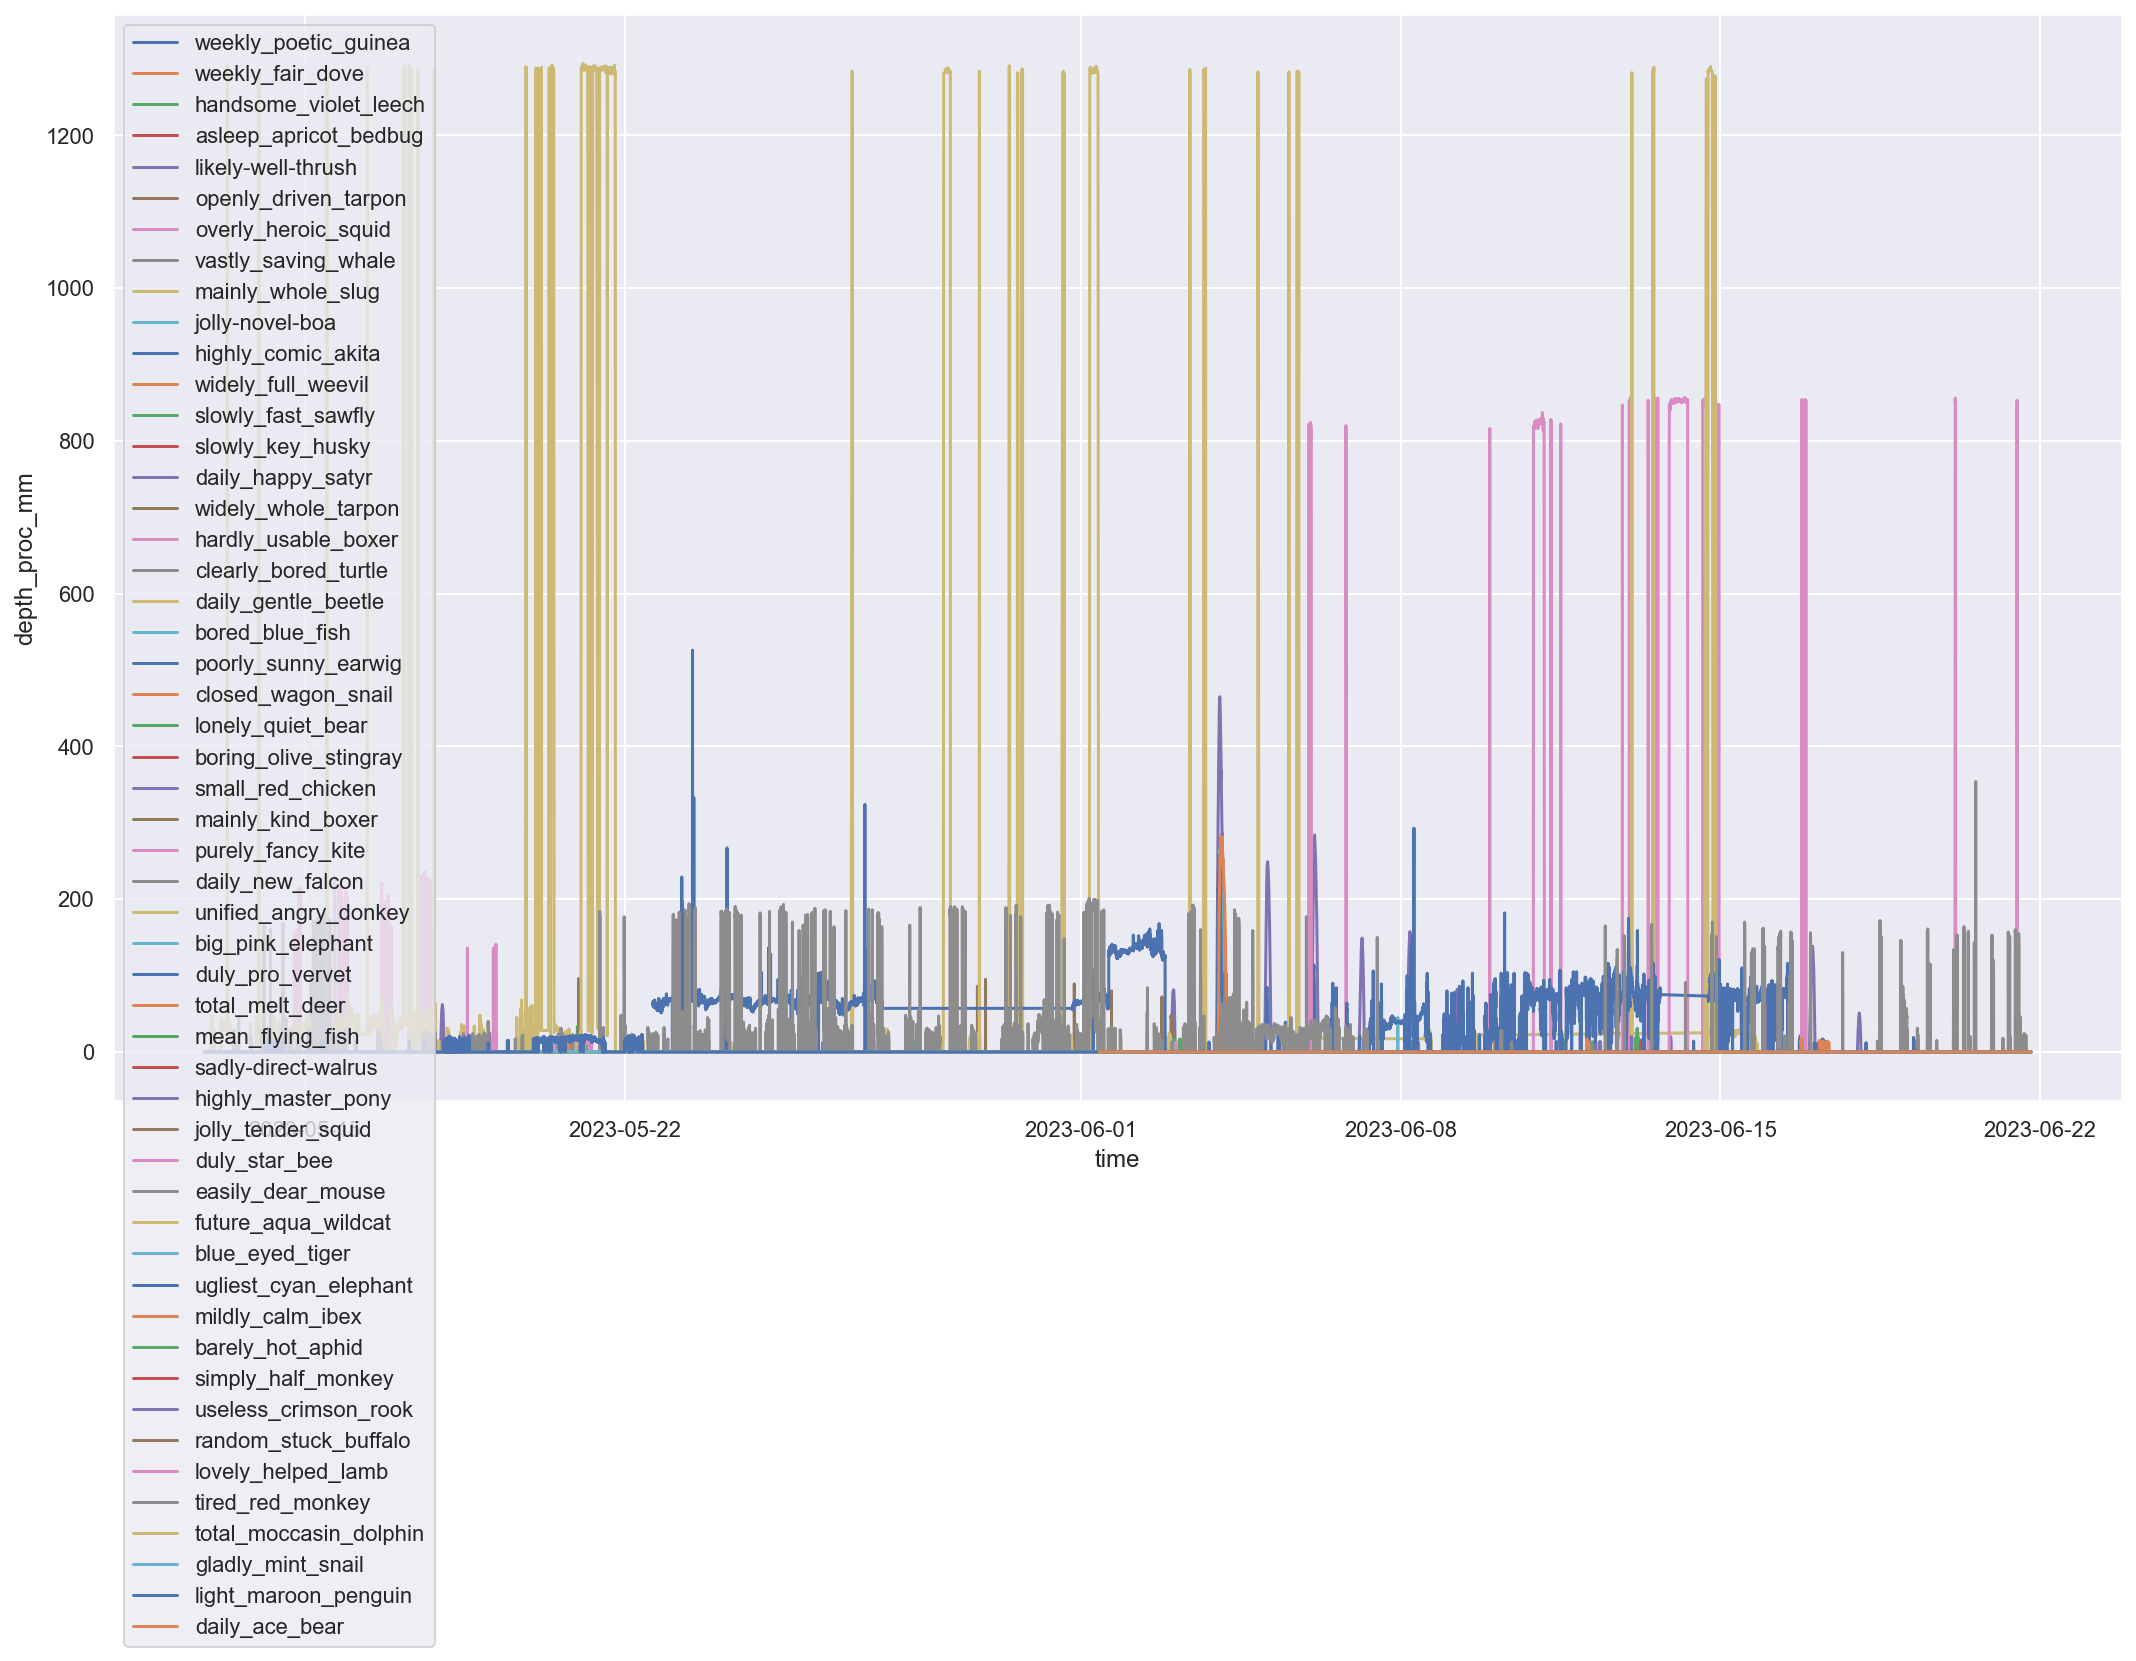

In [22]:
fig, ax = plt.subplots(figsize=(18,10))
dplis = list({i for i in all_dep['deployment_id']})
k = 0
for s in dplis:
  # if k != 13:
    sub = all_dep.loc[all_dep['deployment_id'] == s].copy().dropna()
    #sub['smooth_bv'] = gaussian_filter1d(sub['batt_v'], sigma=600)
    sns.lineplot(data = sub, x = 'time', y = 'depth_proc_mm',label = s)
plt.savefig('52_sensors_20d_depth_pattern_40d')

In [67]:
wnames = set()

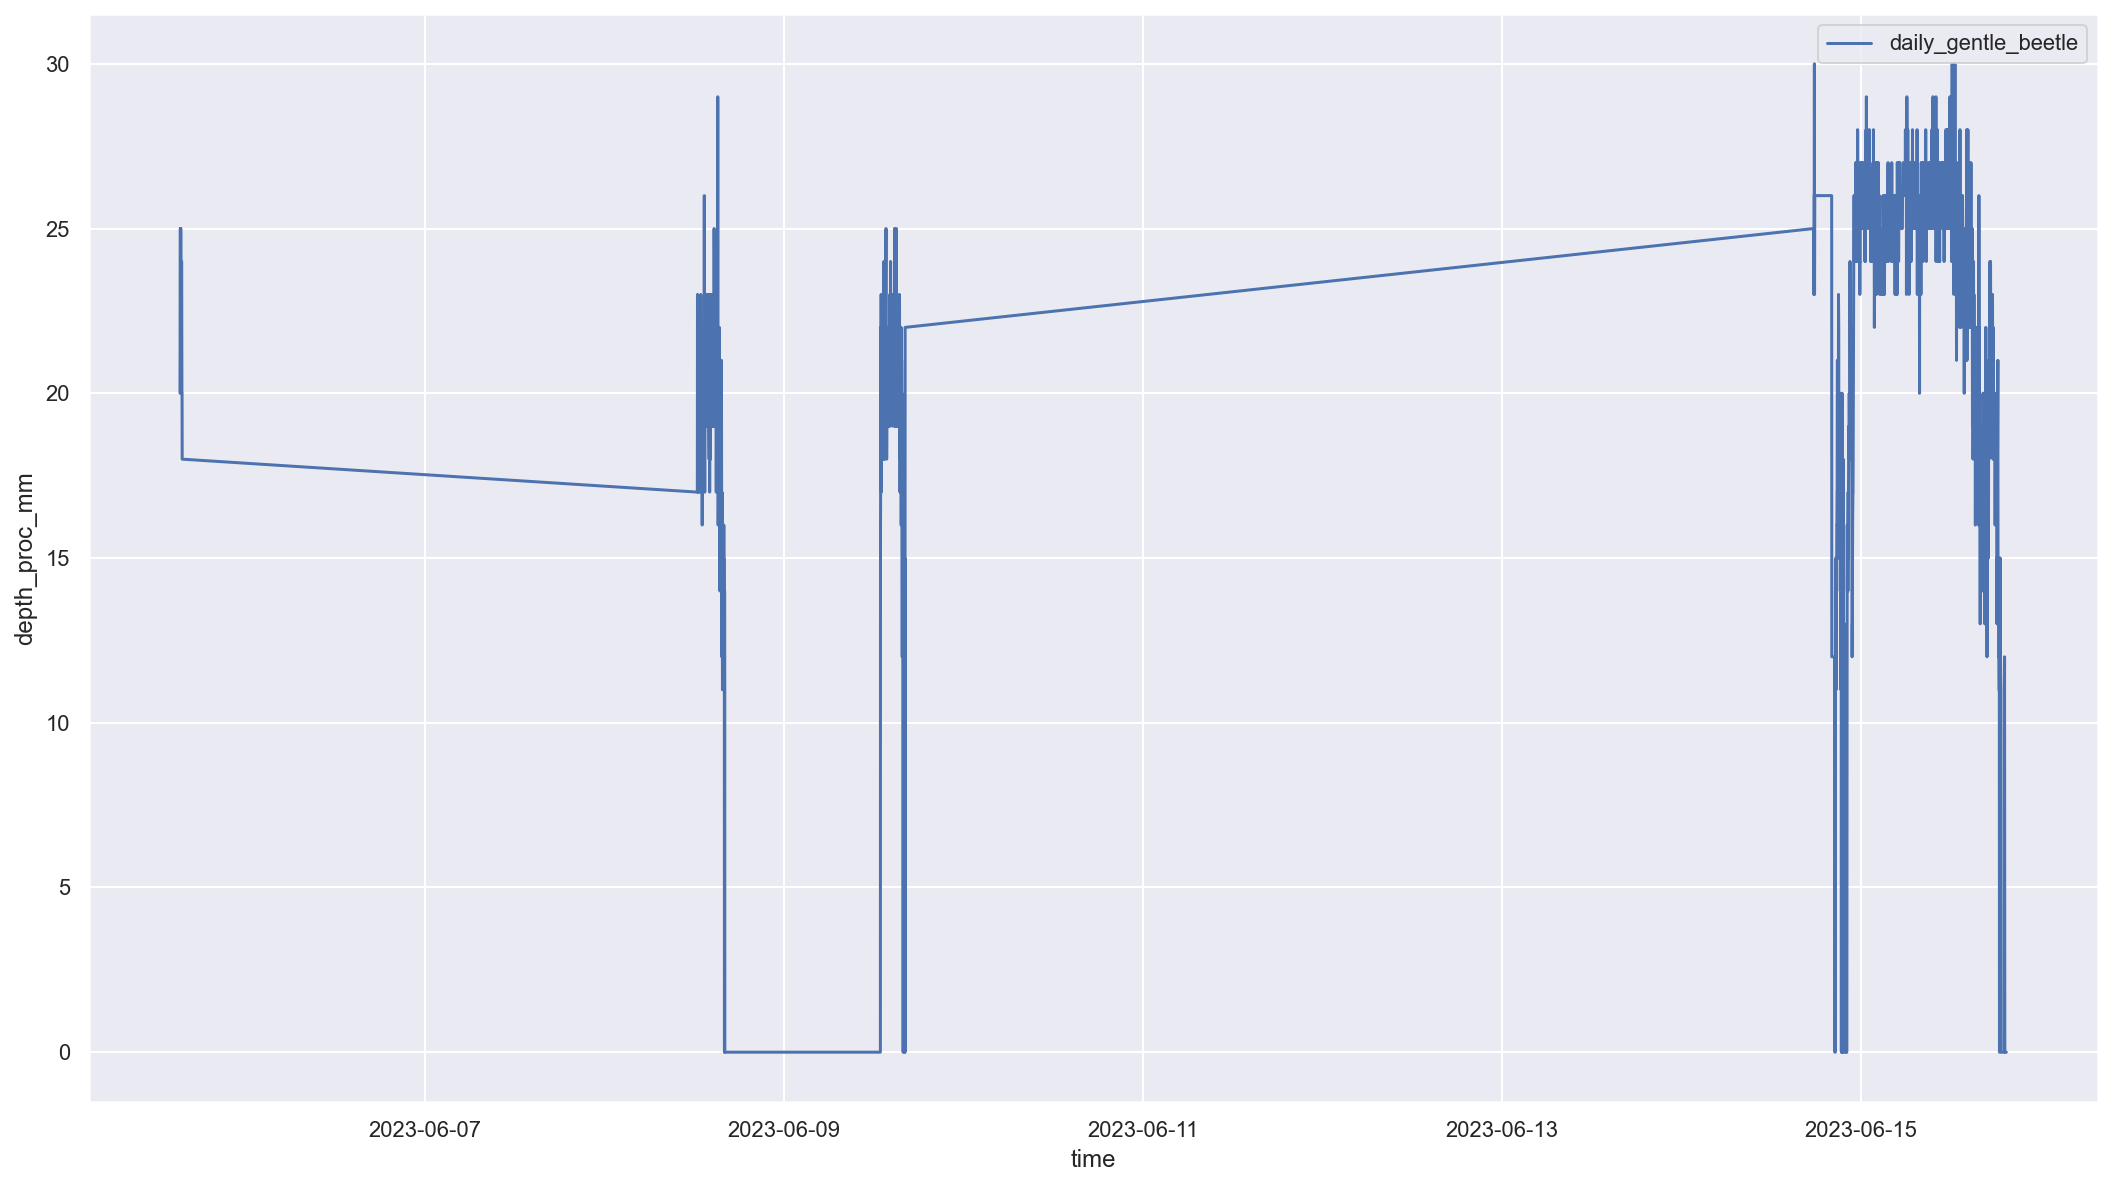

In [68]:
# the wierd case
name = 'daily_gentle_beetle'
wnames.add(name)
sub = all_dep.loc[all_dep['deployment_id'] == name].dropna()
#sub['smooth_bv'] = gaussian_filter1d(sub['batt_v'], sigma=60)
sns.lineplot(data = sub, x = 'time', y = 'depth_proc_mm', label = name)
plt.savefig(f'wierd_case_{name}')

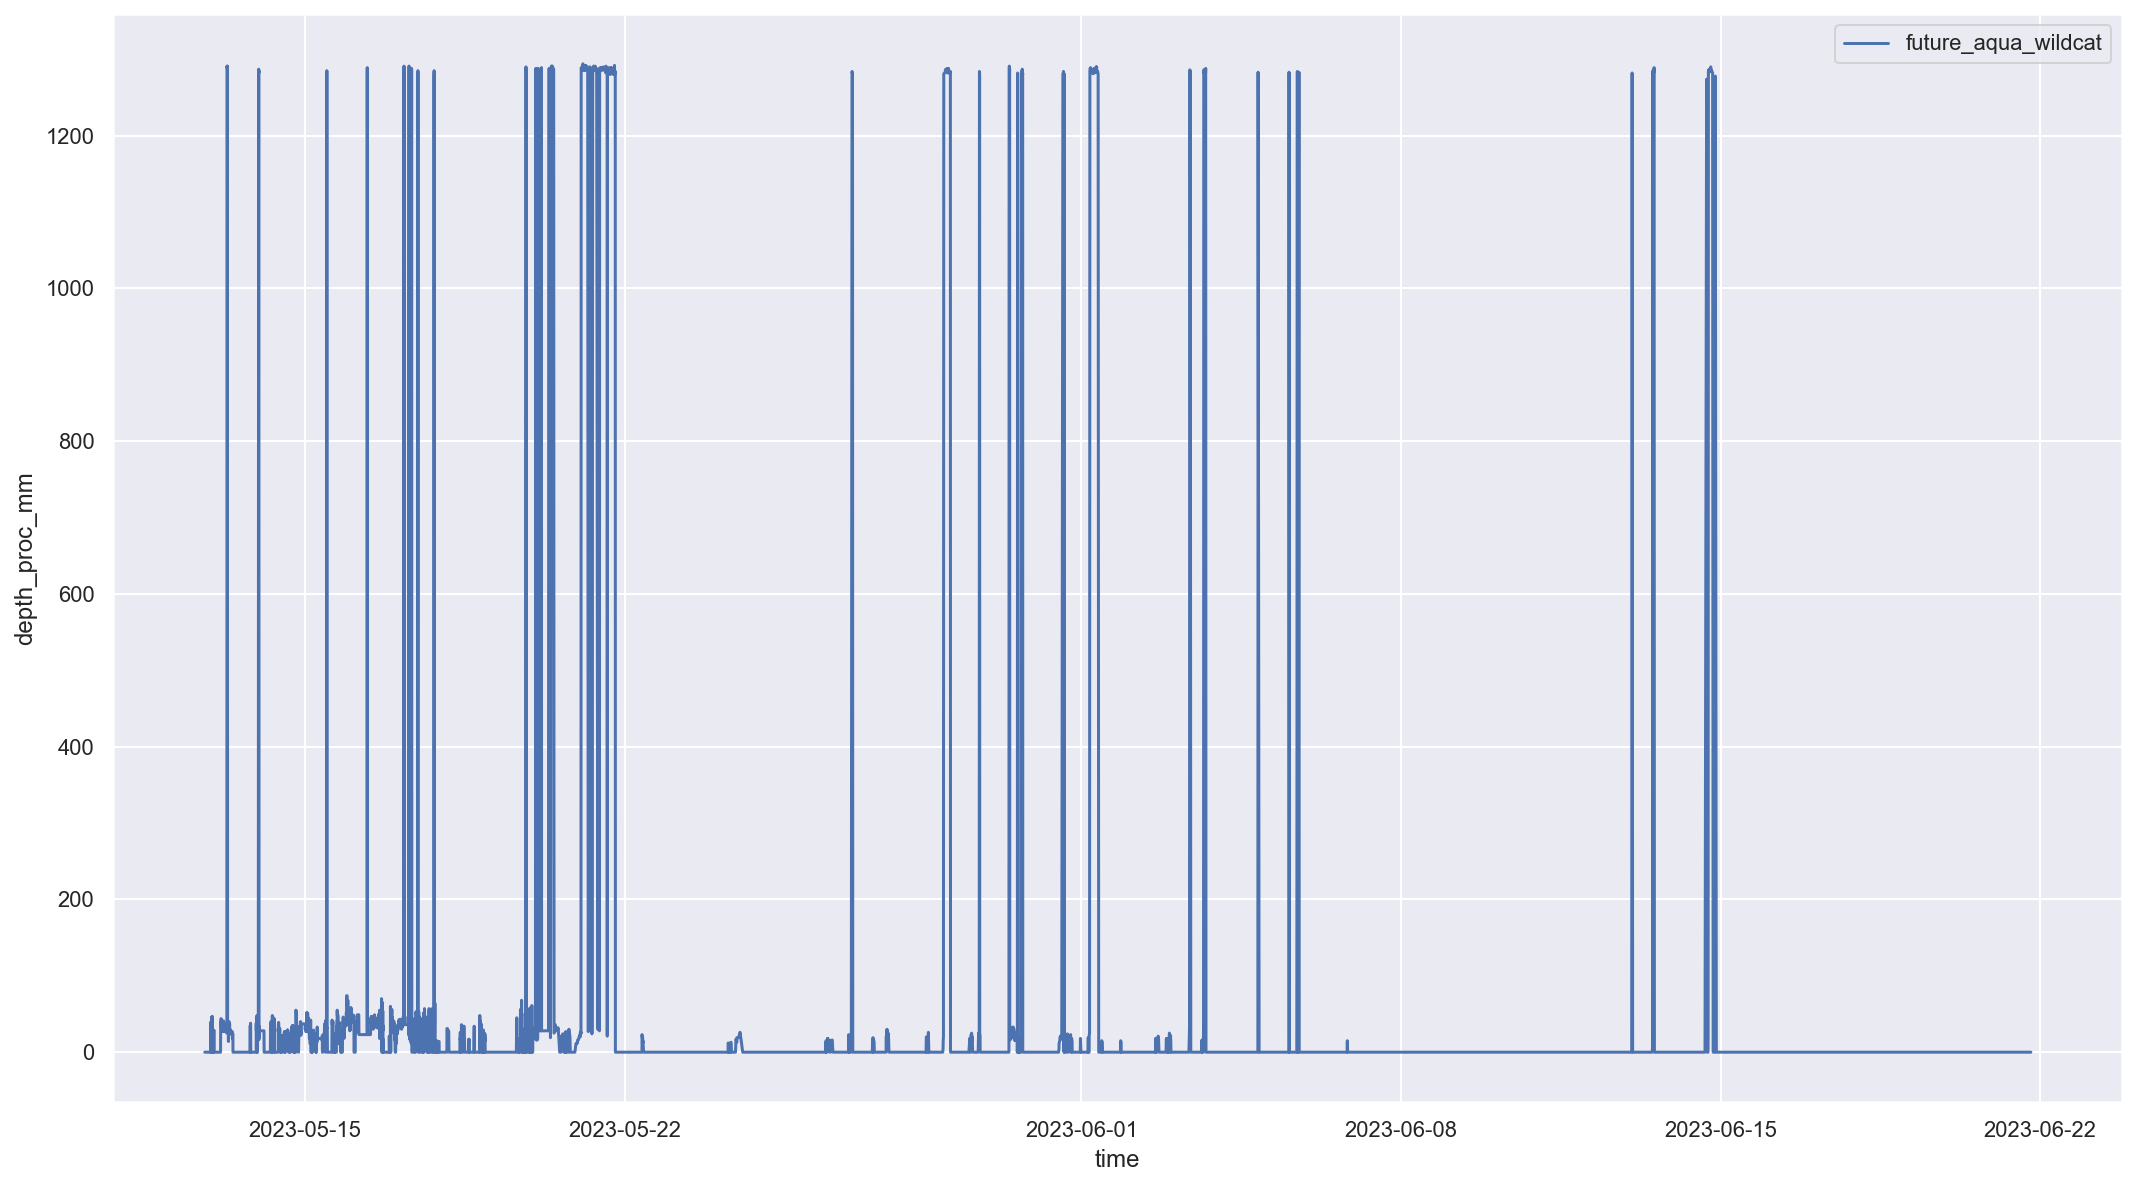

In [69]:
# the wierd case
name = 'future_aqua_wildcat'
wnames.add(name)
sub = all_dep.loc[all_dep['deployment_id'] == name].dropna()
#sub['smooth_bv'] = gaussian_filter1d(sub['batt_v'], sigma=60)
sns.lineplot(data = sub, x = 'time', y = 'depth_proc_mm', label = name)
plt.savefig(f'wierd_case_{name}')

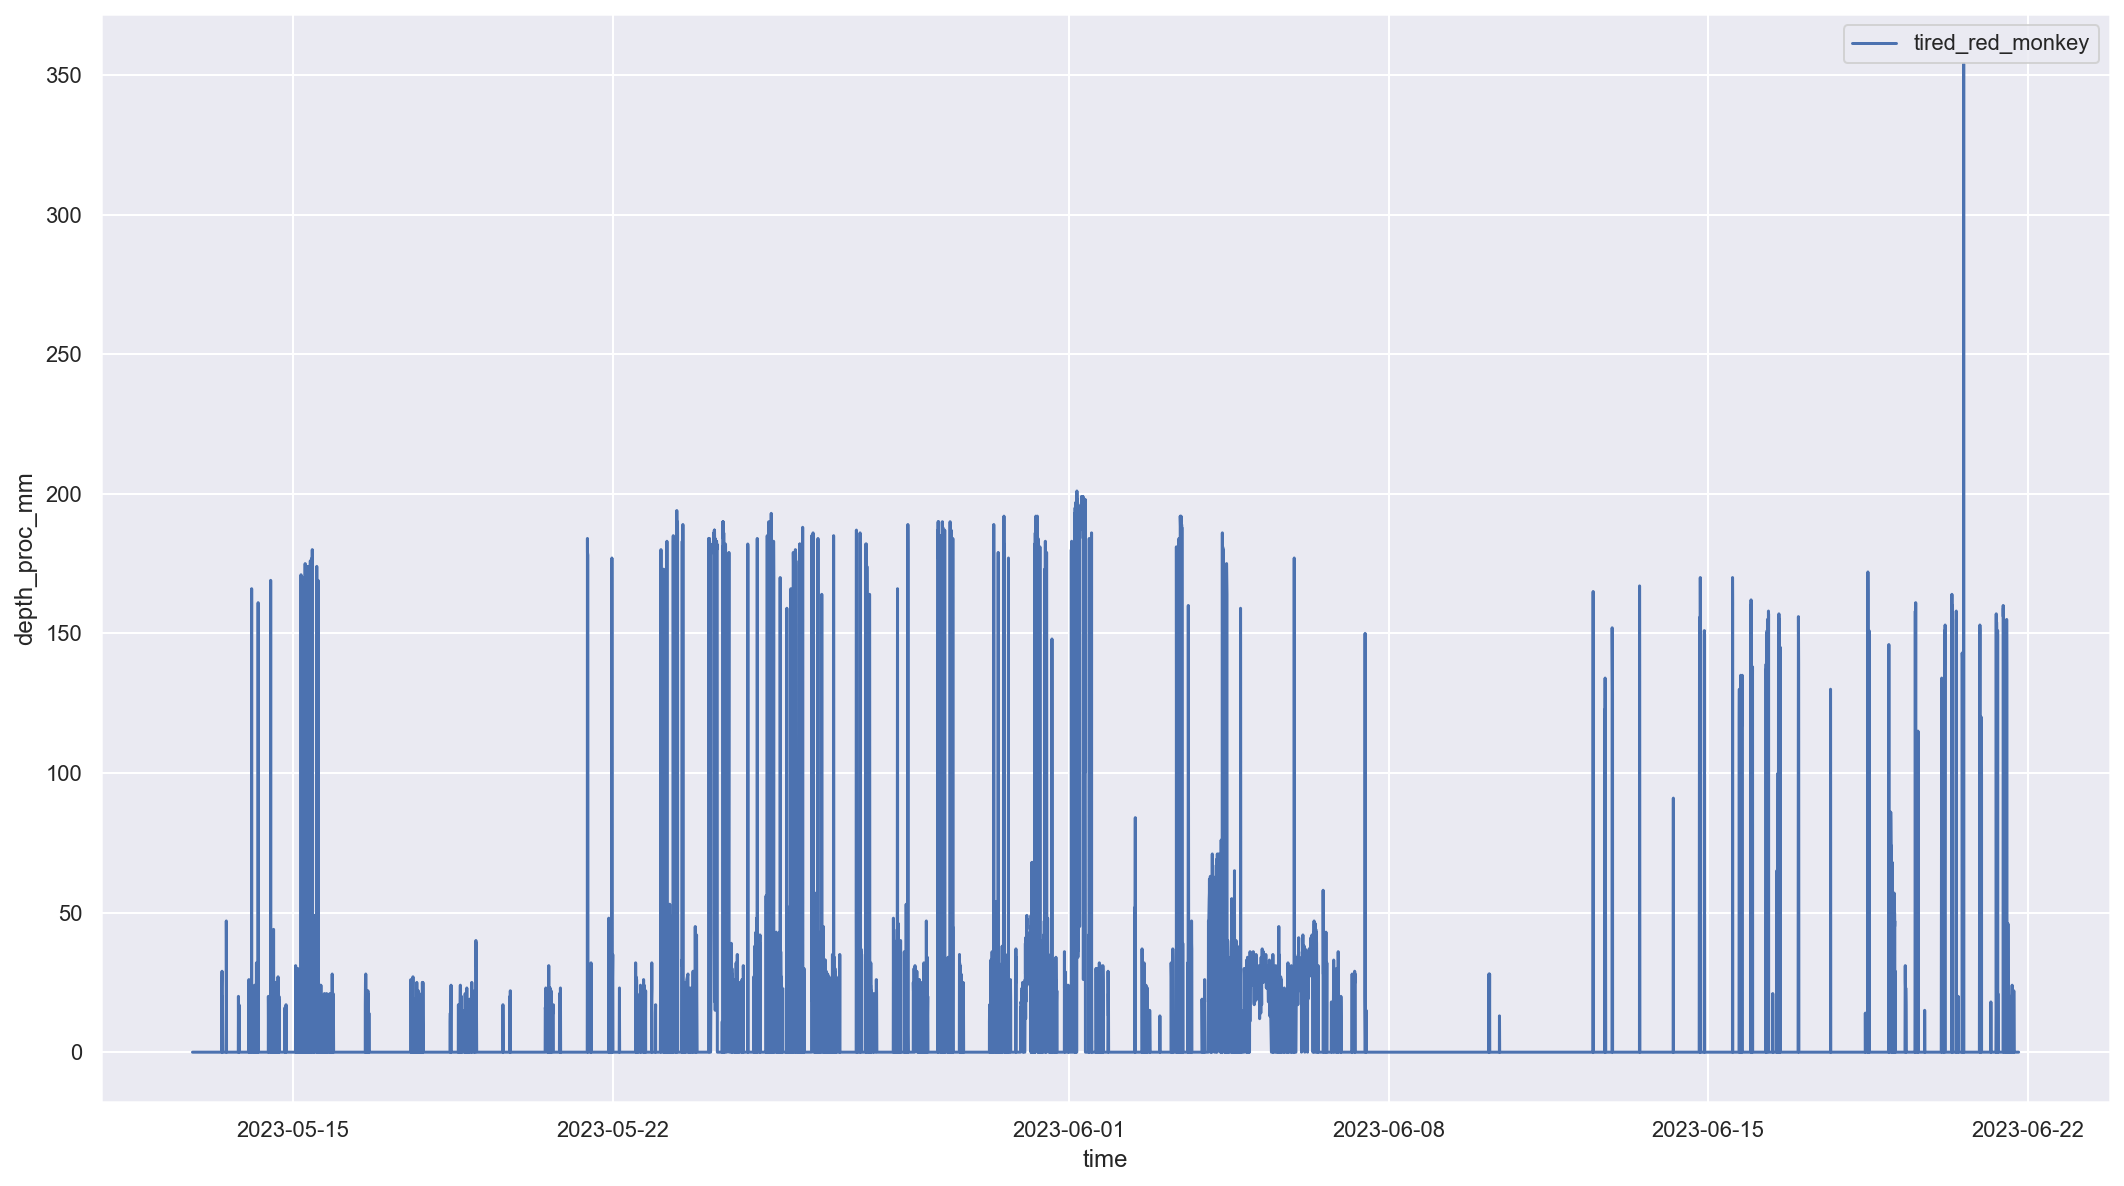

In [70]:
# the wierd case
name = 'tired_red_monkey'
wnames.add(name)
sub = all_dep.loc[all_dep['deployment_id'] == name].dropna()
#sub['smooth_bv'] = gaussian_filter1d(sub['batt_v'], sigma=60)
sns.lineplot(data = sub, x = 'time', y = 'depth_proc_mm', label = name)
plt.savefig(f'wierd_case_{name}')

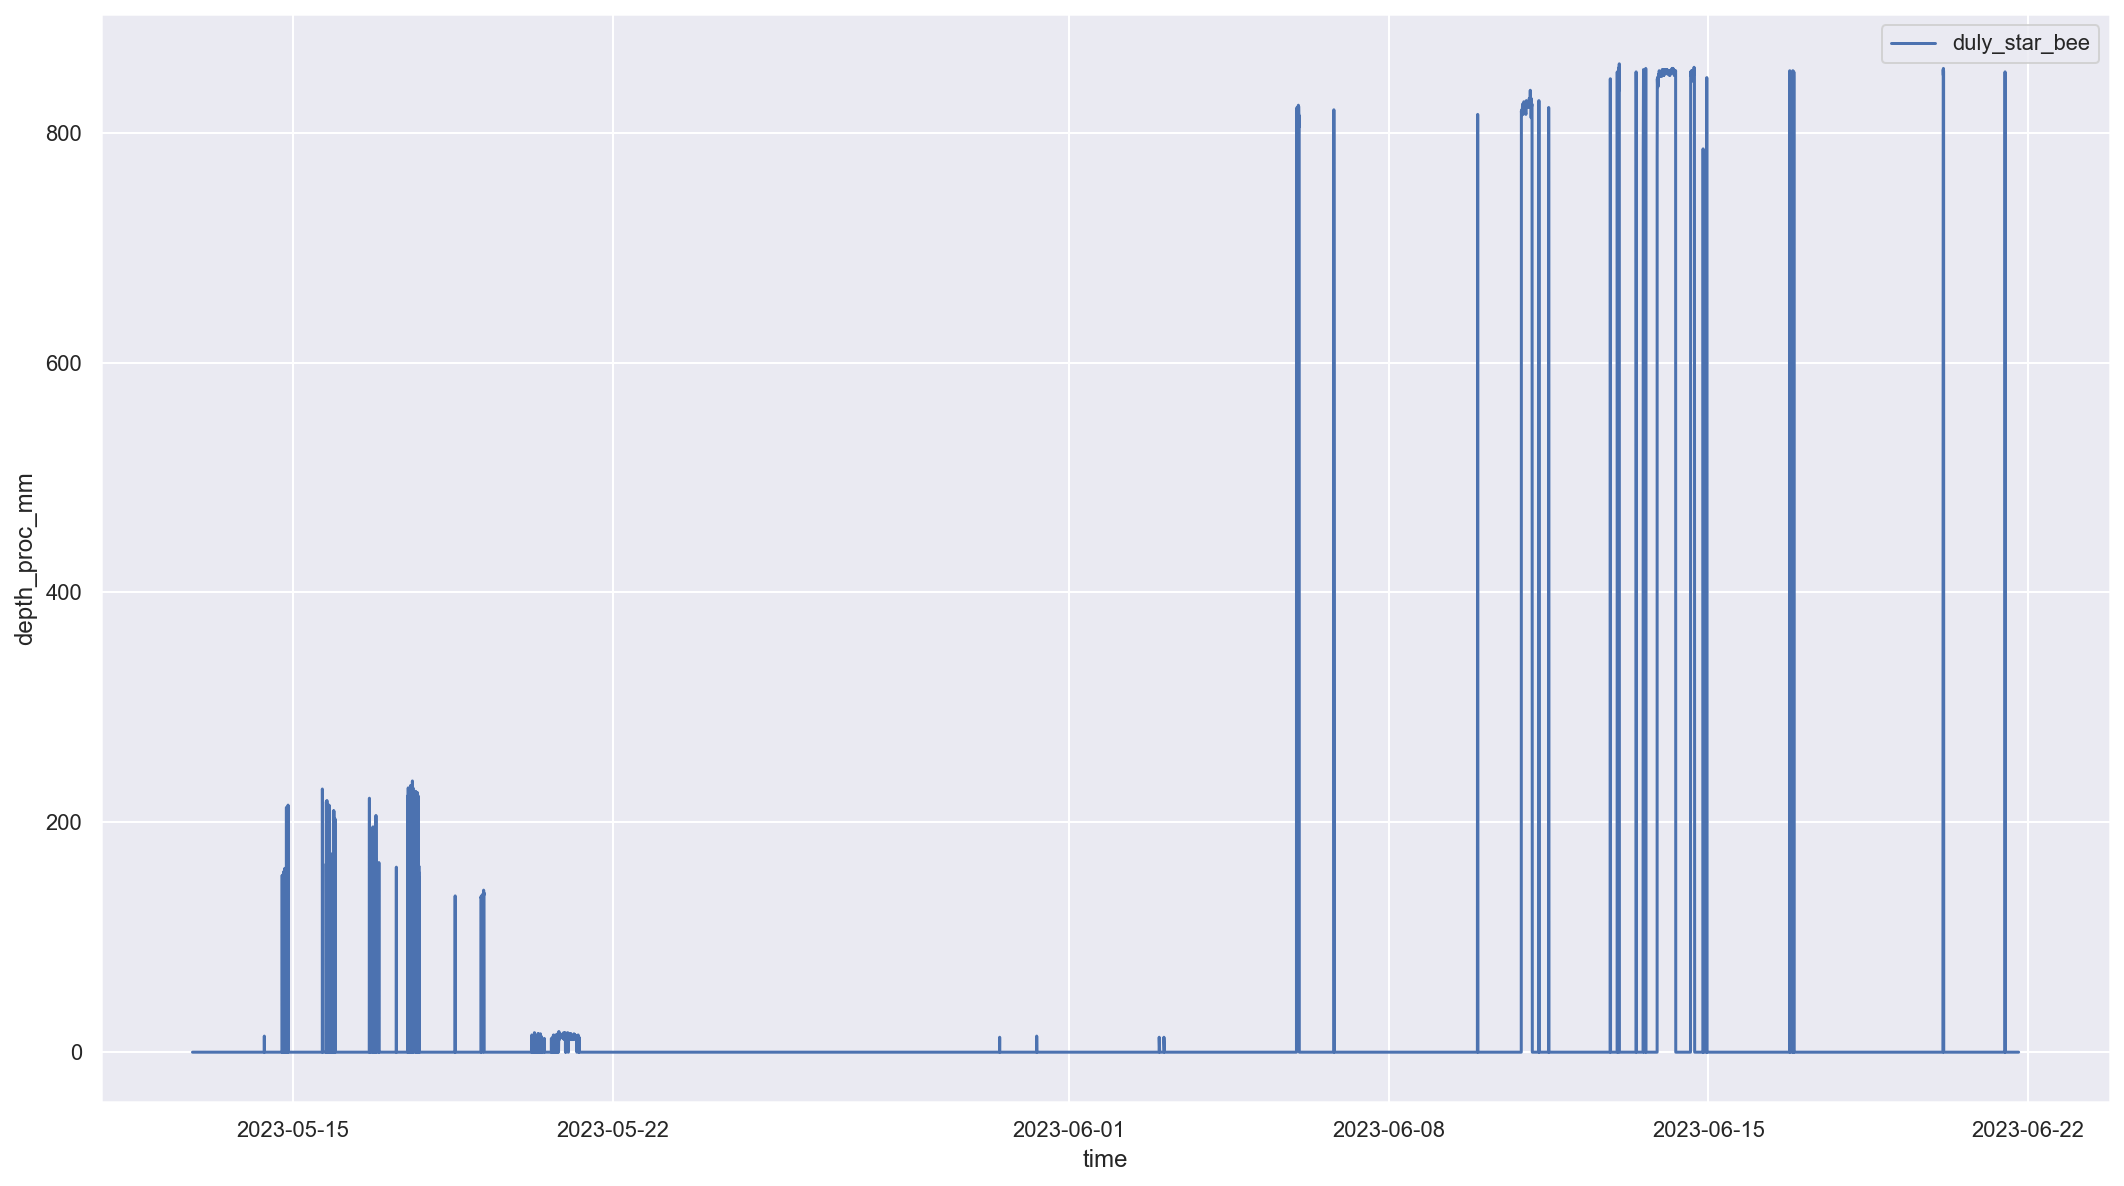

In [71]:
# the wierd case
name = 'duly_star_bee'
wnames.add(name)
sub = all_dep.loc[all_dep['deployment_id'] == name].dropna()
#sub['smooth_bv'] = gaussian_filter1d(sub['batt_v'], sigma=60)
sns.lineplot(data = sub, x = 'time', y = 'depth_proc_mm', label = name)
plt.savefig(f'wierd_case_{name}')

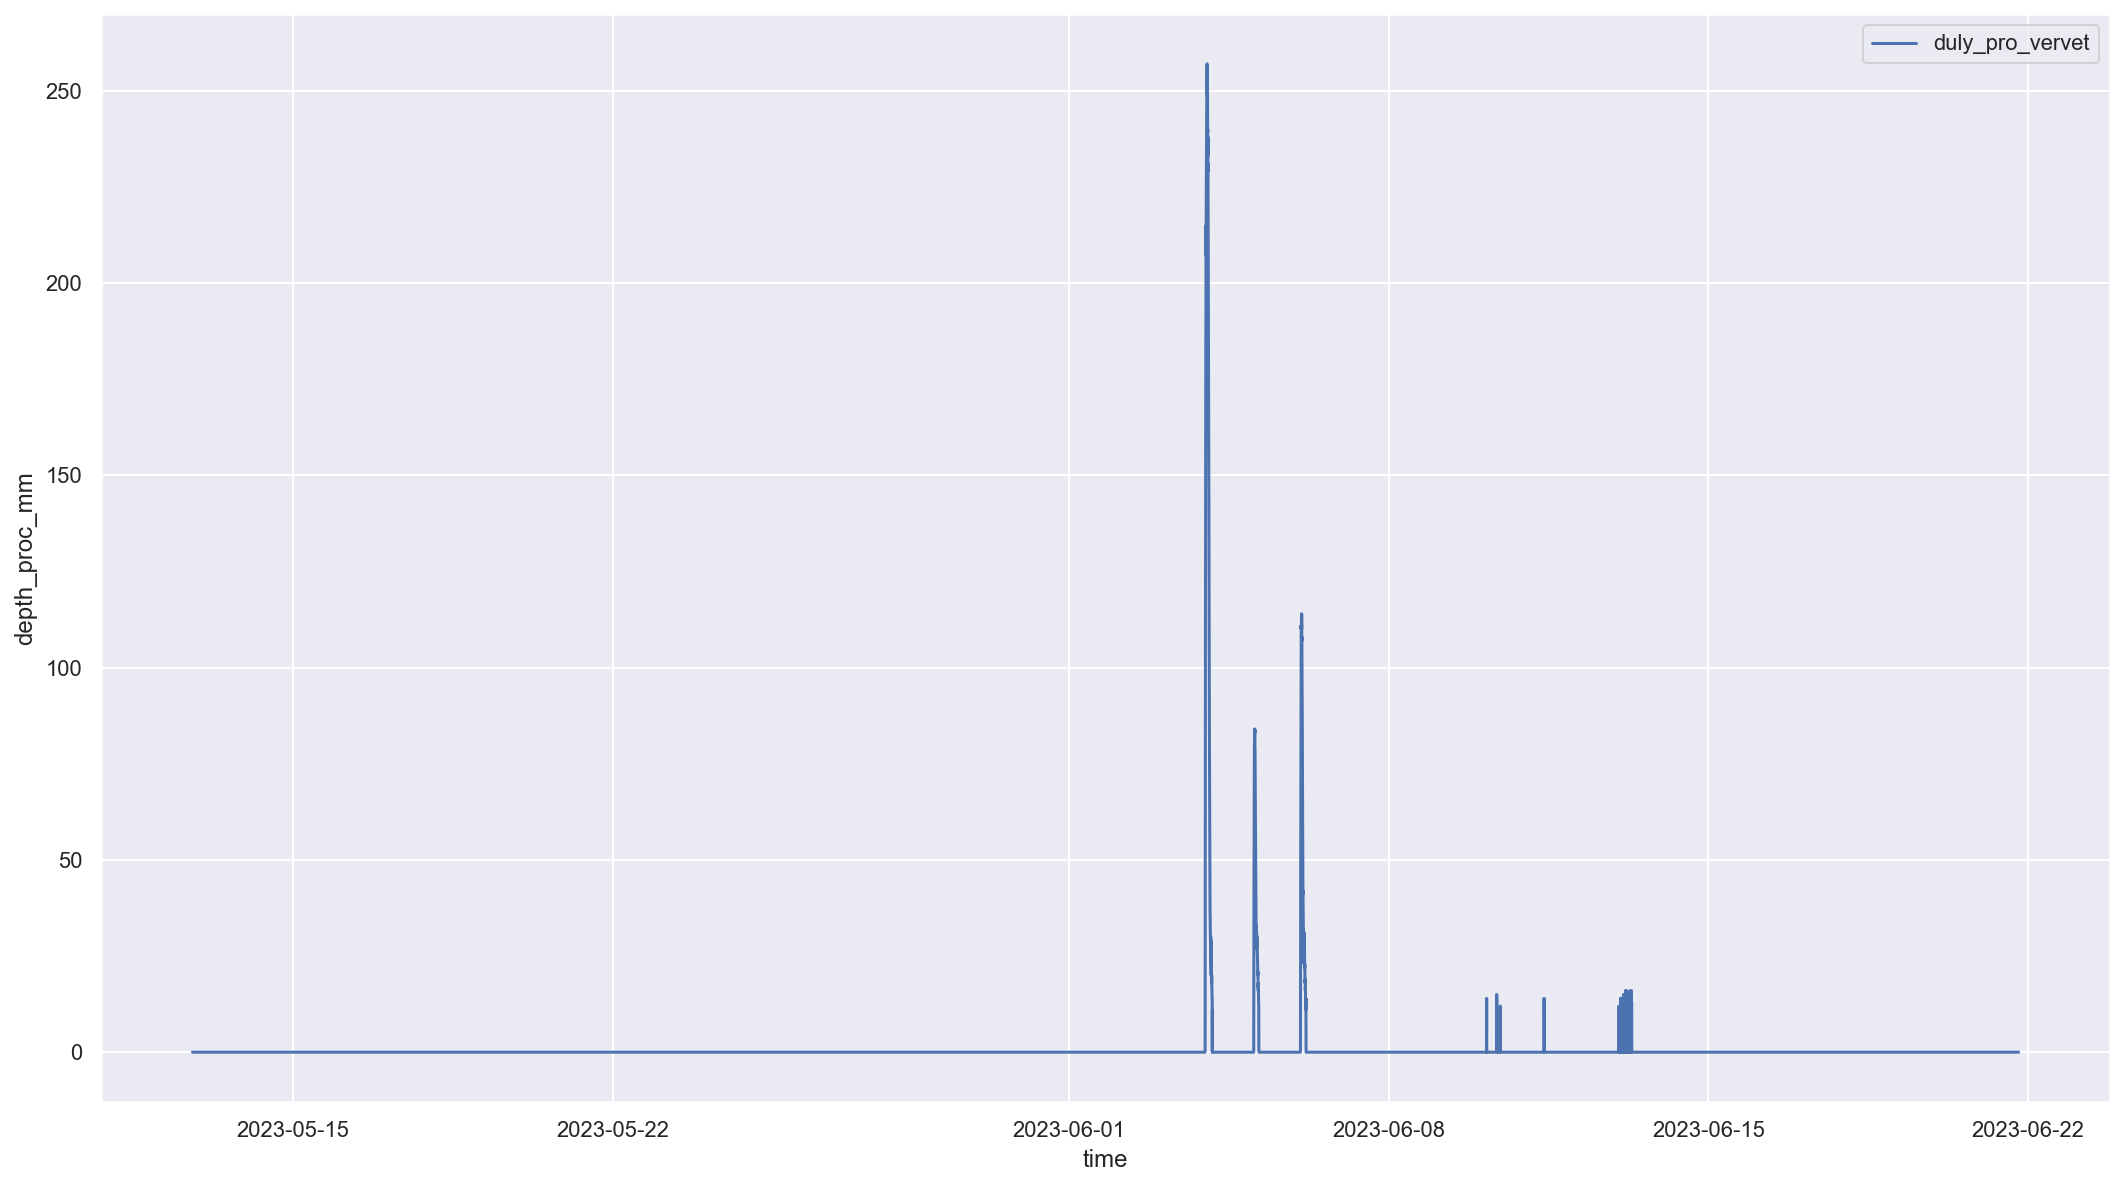

In [72]:
# the wierd case
name = 'duly_pro_vervet'
wnames.add(name)
sub = all_dep.loc[all_dep['deployment_id'] == name].dropna()
#sub['smooth_bv'] = gaussian_filter1d(sub['batt_v'], sigma=60)
sns.lineplot(data = sub, x = 'time', y = 'depth_proc_mm', label = name)
plt.savefig(f'wierd_case_{name}')

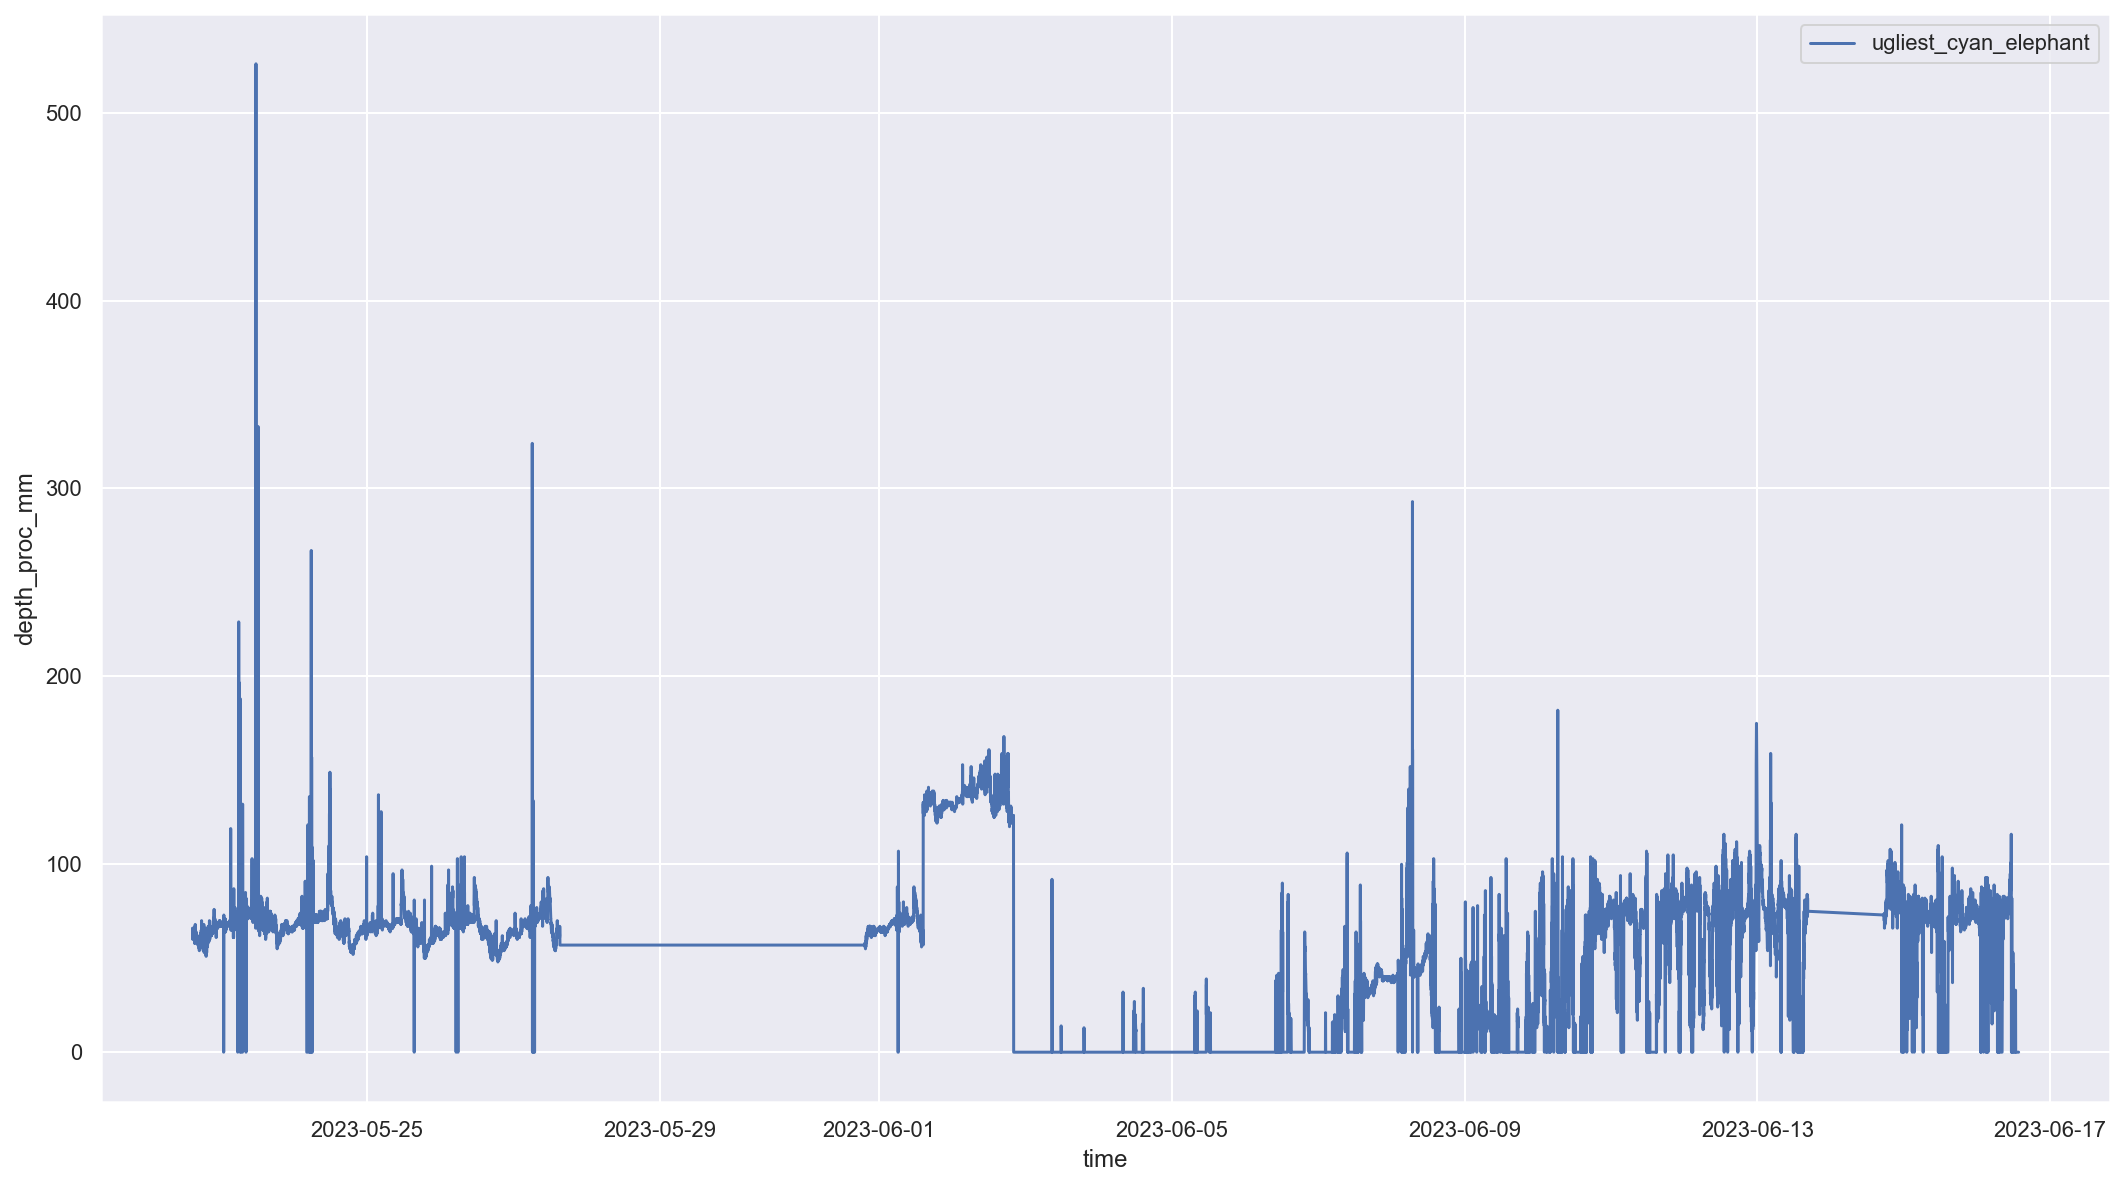

In [73]:
# the wierd case
name ='ugliest_cyan_elephant'
wnames.add(name)
sub = all_dep.loc[all_dep['deployment_id'] == name].dropna()
#sub['smooth_bv'] = gaussian_filter1d(sub['batt_v'], sigma=60)
sns.lineplot(data = sub, x = 'time', y = 'depth_proc_mm', label = name)
plt.savefig(f'wierd_case_{name}')

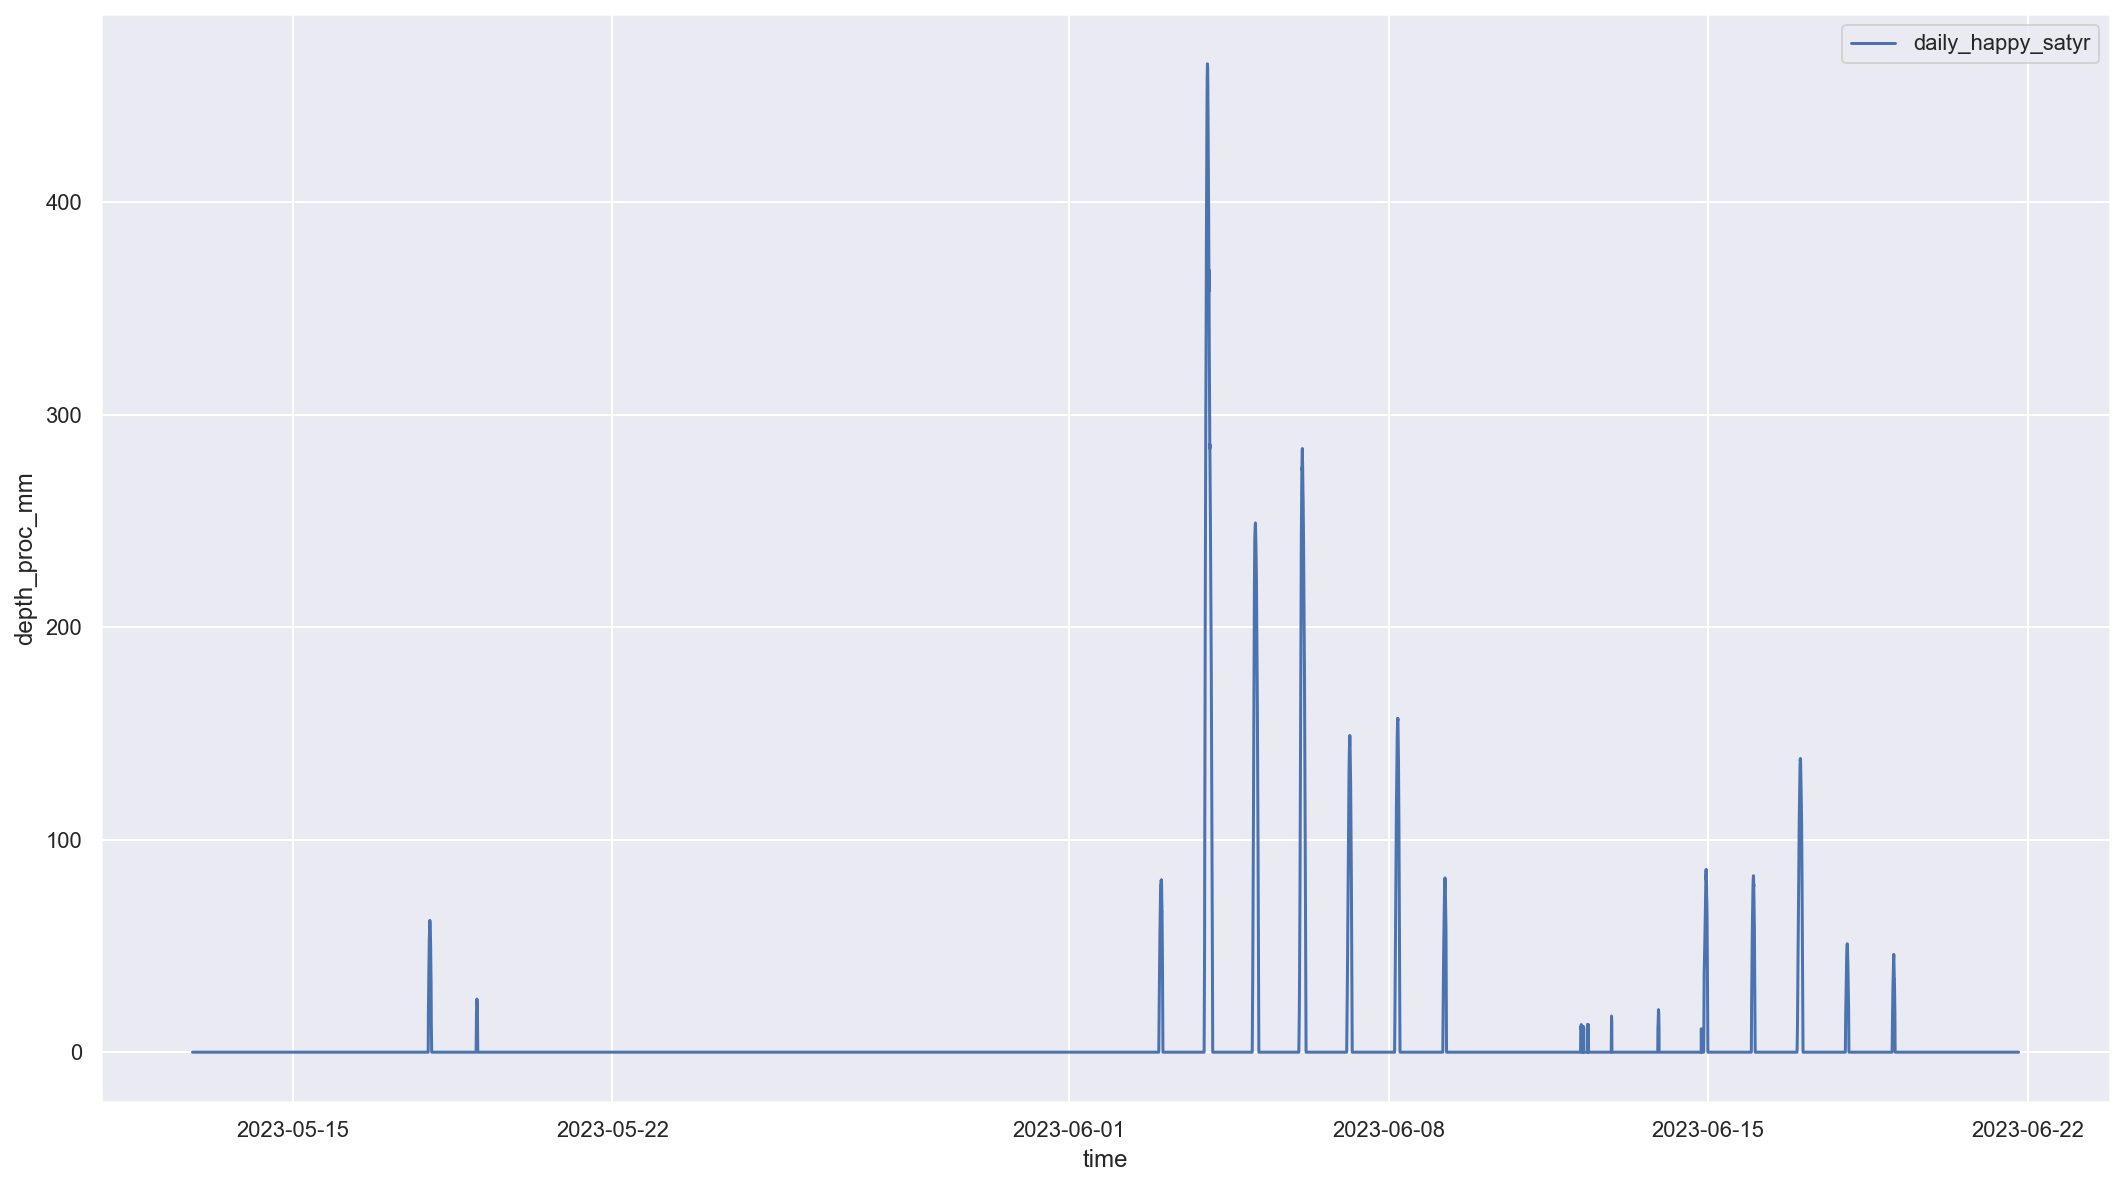

In [74]:
# the wierd case
name ='daily_happy_satyr'
wnames.add(name)
sub = all_dep.loc[all_dep['deployment_id'] == name].dropna()
#sub['smooth_bv'] = gaussian_filter1d(sub['batt_v'], sigma=60)
sns.lineplot(data = sub, x = 'time', y = 'depth_proc_mm', label = name)
plt.savefig(f'wierd_case_{name}')

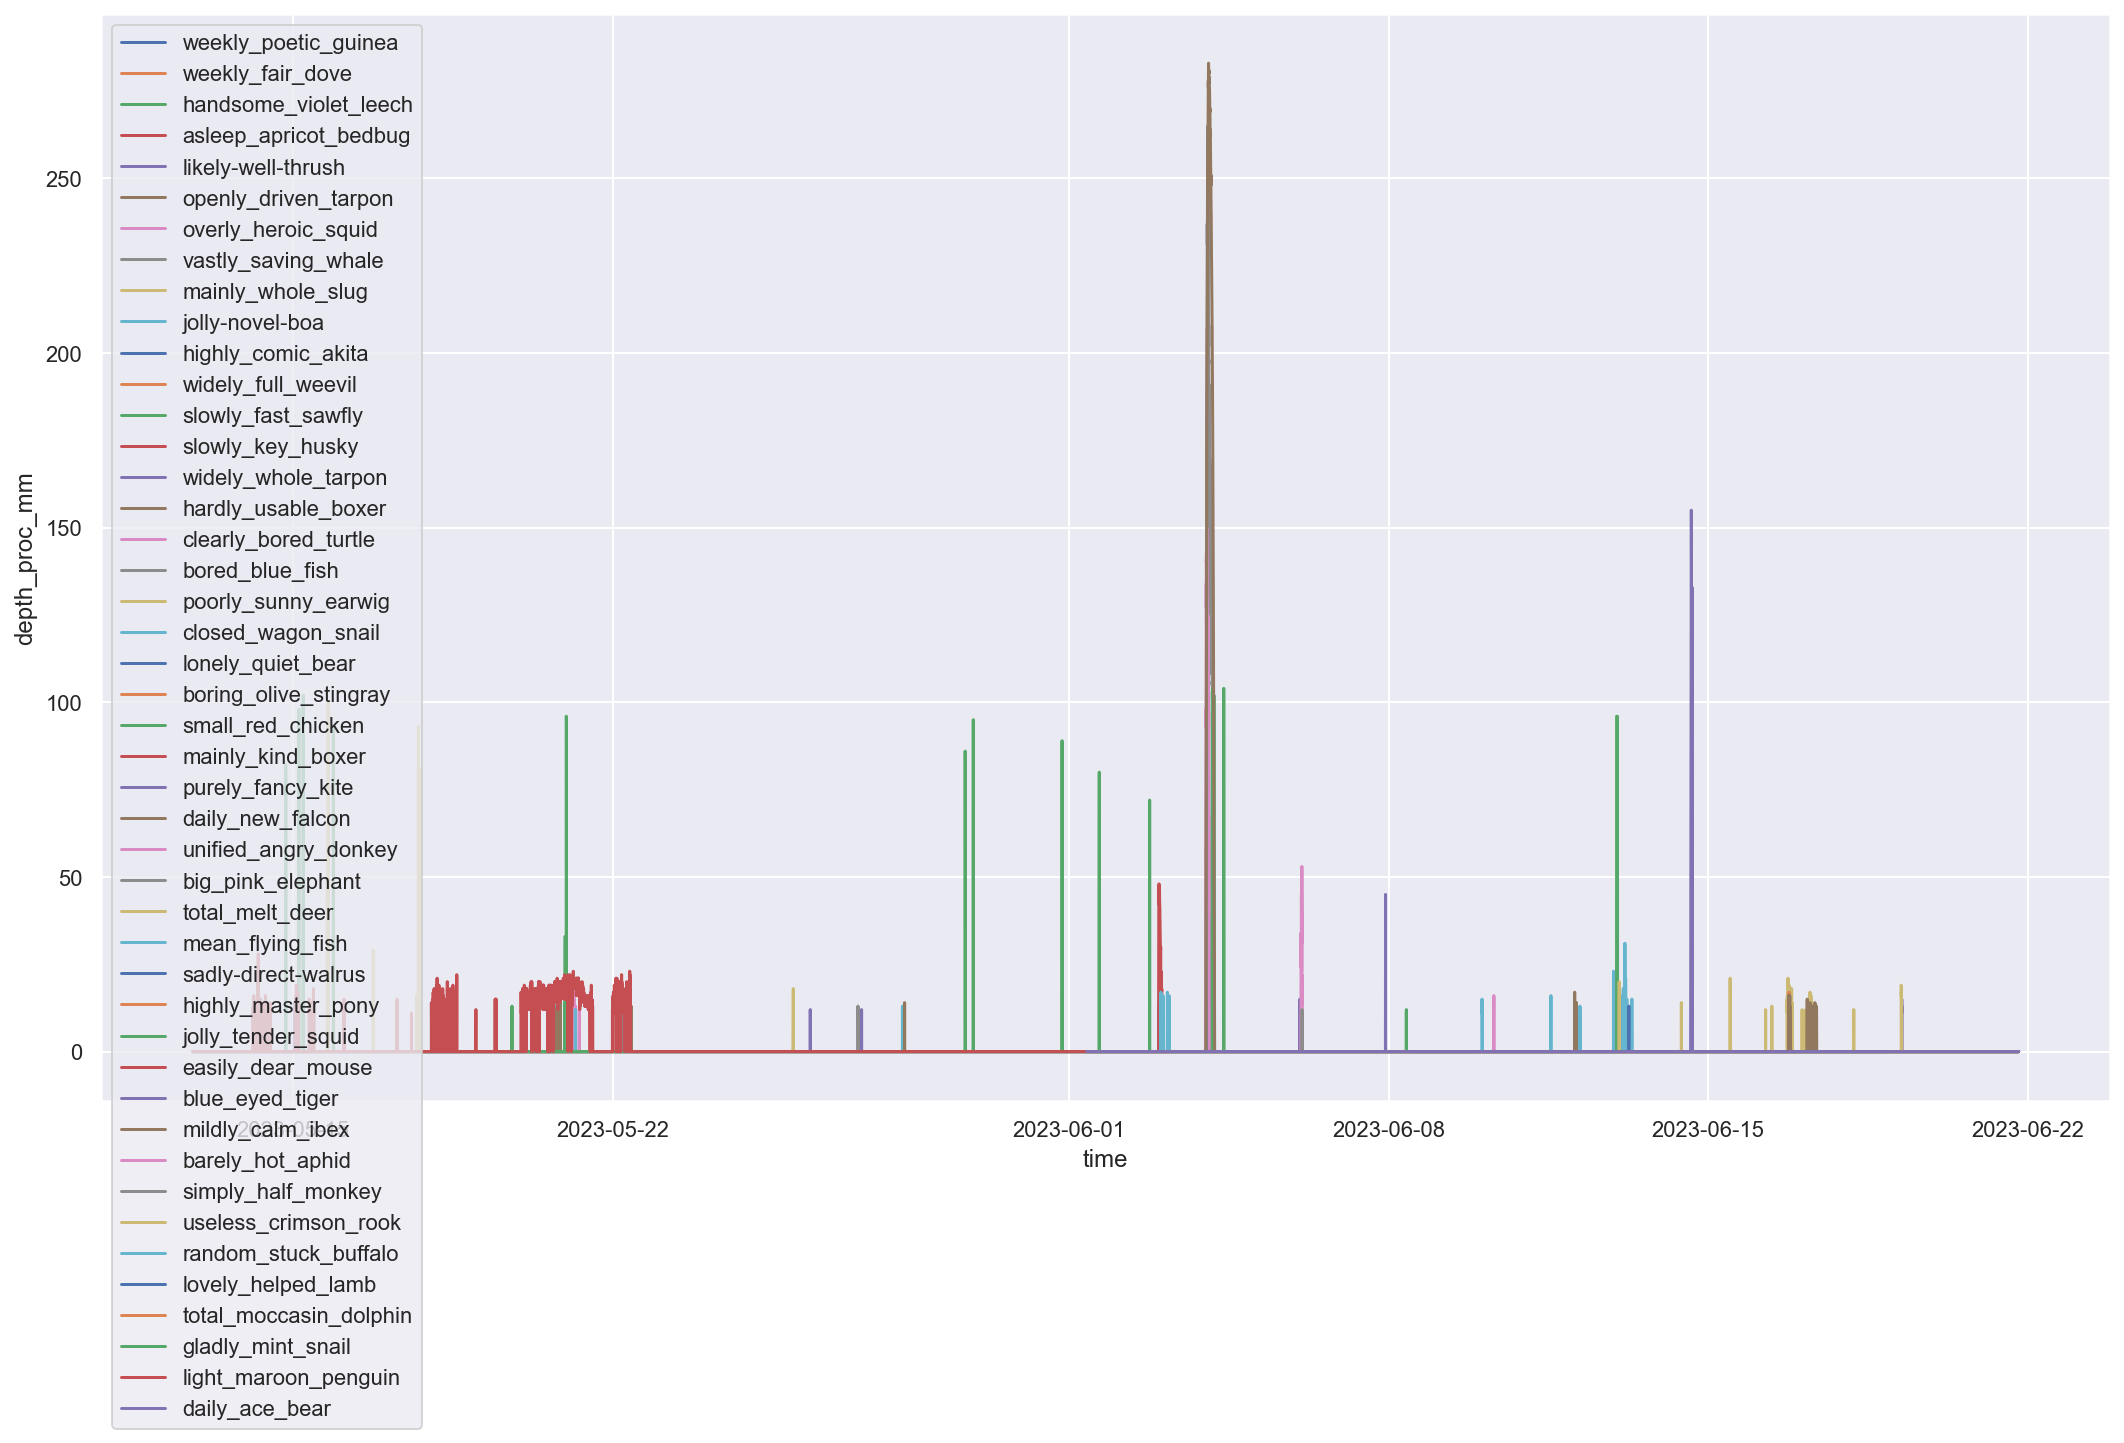

In [75]:
fig, ax = plt.subplots(figsize=(18,10))
dplis = list({i for i in all_dep['deployment_id']})
k = 0
for s in dplis:
    if s not in wnames:
        sub = all_dep.loc[all_dep['deployment_id'] == s].copy().dropna()
        #sub['smooth_bv'] = gaussian_filter1d(sub['batt_v'], sigma=600)
        sns.lineplot(data = sub, x = 'time', y = 'depth_proc_mm',label = s)
plt.savefig('no_wierd_sensors_20d_depth_pattern_40d')